# RainMap Aureli2020

This 2D rainfall runoff test is based on the paper of [Aureli 2020] (https://iwra.org/member/congress/resource/abs478_article.pdf), which compare a numerical model against a laboratory experiment. This configuration consists in an inclined plane in 3 zones presenting different slopes and rain intensities. A constant friction is applied on the inclined plane. The outlet hydrograph is used for comparing models results against experiments mesurements. 
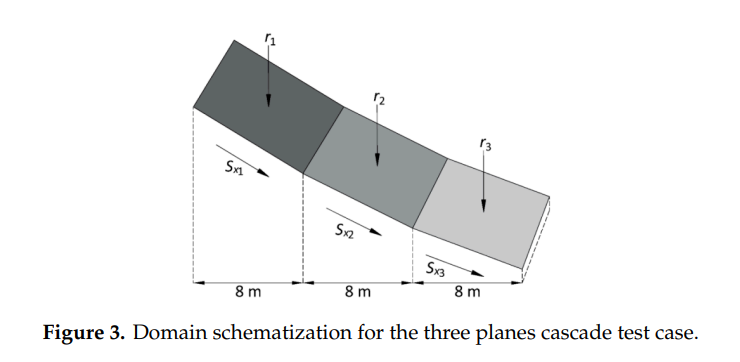(from *Aureli2020*)

## Pyton set-up

########!pip install -r requierements.txt to automatically install the good libraries (or .yml file shared)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from scipy import interpolate
from scipy.interpolate import LinearNDInterpolator
from subprocess import Popen, PIPE

import xarray as xr
import os
import shutil
from netCDF4 import Dataset
import netCDF4 as nc4
import utm

## Read text file given its name (and path), number of columns, number of header lines
def readCSV_Ncol(name,n_col,n_pass):
    X=[]
    for i in range(n_col):
        X.append([])

    f=open(name,'r')
    n_line=0
    for line in f.readlines():
        if n_line<n_pass:
            n_line = n_line+1
        else:
            sline=line.split(',')
            for i in range(n_col):
                X[i].append(float(sline[i]))
    f.close()
    return(X)

In [2]:
myDir='auto_Aureli2020_RainMap2'

codeDir = r"C:\Users\haranga\BG-Flood\Test_Cases_Alice\CodeDir"
execDir = r"C:\Users\haranga\BG-Flood\VS_BG-flood\BG_flood\x64\Release"

if not os.path.isdir (myDir):
    os.mkdir(myDir)
os.chdir(myDir)
MyDir = os.getcwd()
MyDir

'C:\\Users\\haranga\\BG-Flood\\Test_Cases_Alice\\auto_Aureli2020_RainMap2'

## Preparation of the bathymetry
The bathymetry is directly created using the description in the paper. We choose to have full blocks in both direction, so dx is forced to have exactly 22 blocks in the y direction. The x end of the model is then adjusted (a little further than the experiment set-up) to have full blocks too for square blocks and cells.

In [3]:
xo=0
yo=0
xf_min=28.0
yf=0.196
ny = 16
dx=(yf-yo)/ny
y=np.linspace(yo, yf, ny);
xf=xo + (16*dx) * np.ceil((xf_min - xo) / (16*dx));
nx=int((xf-xo)/dx)
x=np.linspace(xo, xf, nx);
dx

0.01225

In [4]:
xi=5.0;
yi=1.52/2;
slope_d=8;
base_r=0.75/2;
top_r=0.05/2;
hi=0.049;

z= np.zeros((ny,nx))

for i in range(nx):
    for j in range (ny):
        if x[i]<8:
            z[j,i] = 0.2 + (8.0 - x[i]) * 2.0 / 100.0
        elif x[i]<16:
            z[j,i] = 0.08 + (16.0 - x[i]) * 1.5 / 100.0
        else:
            z[j,i] = 0.0 + (24.0 - x[i]) * 1.0 / 100.0

In [5]:
Zinit = z[0,np.where(x>27)[0]][0]
Zinit

-0.03010805421950156

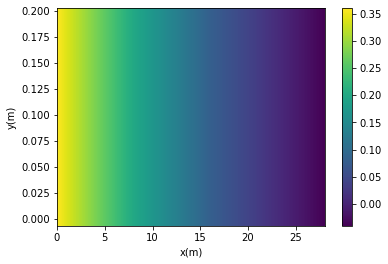

In [6]:
X,Y = np.meshgrid(x,y)
plt.pcolormesh(X,Y,z, shading='auto')
plt.colorbar()
plt.xlabel("x(m)")
plt.ylabel("y(m)")
plt.savefig('bathymetry.png')
fig1=plt.gcf()
plt.show()

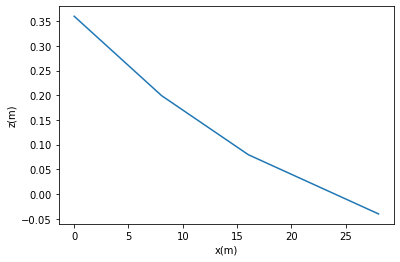

In [7]:
plt.plot(x,z[1,:],'-')
plt.xlabel("x(m)")
plt.ylabel("z(m)")
plt.show()

Saving it in a netcdf file

In [8]:
ds = xr.Dataset(
      {"z": (("y", "x"), z)},
      coords={
          "x": x,
          "y": y,
      },
  )

ds.to_netcdf("bathy.nc")

# Creation of the rain forcing
In this configuration, the code will be forced by a rain map which is spacially variable and also variable in time.

## Writing the rain forcing file
The boundary condition file will be defined by a time serie with a column for time, and on for millimeters of rain.
The rain will last 10s and will be of 3888 mm/h on the top zone with a 2% slope, 2296.8 mm/h in the middle zone with a 1.5% slope and 2880 mm/h in the bottom zone with a 1% slope.

*Note: for the netcdf file, a regular grid is expected in the spacial space but not in the temporal one. (x should be regularly spaced but the dt may be not constant)*

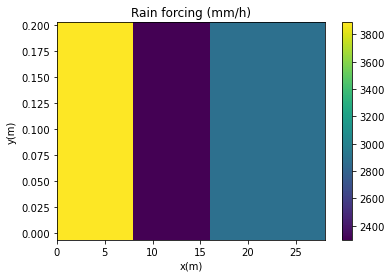

In [9]:
#Tr=[0.0,10.0,10.0001,20.0]; #Rain duration of 10s
#not working yet

Tr=np.linspace(0.0, 80.0, 801);


Rz = [3888, 2296.8, 2880]; #mm/hr
#Rz = [3888, 3888, 3888]; #mm/hr : for uniform rain test


r= np.zeros((len(Tr),ny,nx))
for tt in range(len(Tr)):
    for i in range(nx):
        for j in range (ny):
            if Tr[tt]<=10.0:
                if x[i]<8:
                    r[tt,j,i] = Rz[0]
                elif x[i]<16:
                    r[tt,j,i] = Rz[1]
                else:
                    r[tt,j,i] = Rz[2]
            else:
                r[tt,j,i] = 0.0

ds = xr.Dataset(
      {"rain": (("t","y", "x"), r)},
      coords={
          "x": x,
          "y": y,
          "t": Tr,
      },
  )
ds.to_netcdf("rain_forcing.nc")                

X,Y = np.meshgrid(x,y)
plt.pcolormesh(X,Y,r[1,:,:], shading='auto')
plt.colorbar()
plt.xlabel("x(m)")
plt.ylabel("y(m)")
plt.title("Rain forcing (mm/h)")
plt.savefig('rain_forcing.png')
fig1=plt.gcf()
plt.show()

## Writing the BG_Params file
This text file is the main interface to BG_Flood. It contains a list of key words and associated values to modify
the default flow and grid and time keeping parameters, boundary and external forcing, as well as output options and reference values. Different keys can be accepted for the same parameter. (See XXXXX for a detailled list of the input parameters).
The minimum input is the bathymetry file. In this example, we will conserve a simple version of the BG_Params file where only the modified values will be listed:

In [10]:
key=[]
value=[]

* name of the bathymetry file (and variable name associated to altitude (here _z_) if the format is netCDF)

In [40]:
key.append('topofile')
value.append('bathy.nc?z')

* Timekeeping parameters
    * "totaltime"  : Start time for the simulation
    * "endtime" : End of simulation (in s)

In [41]:
key.append('totaltime')
value.append(Tr[0])
key.append('endtime')
value.append(Tr[-1])

* Resolution of the simulation (by default, the resolution of the bathy/topo file is used)

In [42]:
#key.append('dx')
#value.append('0.005')

* Choice of the GPU/CPU mode (-1 if no GPU else 0 for GPU, by default) and precison of the model

In [43]:
#key.append('gpudevice')
#value.append(0)
key.append('doubleprecision')
value.append('1')

* Flow and models parameters
    * "frictionmodel": bottom friction model (-1: Manning model, 0:, 1: Smart model (default, __REF__))
    * "cf": friction coefficient
    * "eps": minimum water elevation
    * "theta": minmod limiter that can be used to tune the momentum dissipation (theta=1 gives minmod, the most dissipative limiter and theta = 2 gives superbee, the least dissipative) (by default 1.3).


In [44]:
key.append('frictionmodel')
value.append('-1')
key.append('cf')
value.append('0.009')
#key.append('eps')
#value.append('0.00000100')
key.append('theta')
value.append('1.14')

* Boundaries condition

Boundaries are refered by their position, using "top/bottom/right/left" keywords. They are associated to a boundary type 
( 0:wall; 1: Neumann (Default); 2:Dirichlet (zs); 3: abs1d) and possibly a file containing a time serie. In this case, the file name is placed before the type, coma-separated. Here, the by-default Neumann type boundary conditions are conserved, but on the left side (top of the slope), where we impose a wall boundary condition. 


In [45]:
key.append('left')
value.append('0')

* Exterior forcings

Different forcinds are available (river, rain, atmospherique pressure...). In this example, we will use the rain forcing. This can be a time serie in a text file if the forcing is uniform on all the domain (like in this case) or a netcdf file if the forcing is space dependent (and time dependent).


In [46]:
key.append('rainfile')
value.append('rain_forcing.nc?rain')

* Initial conditions
    * "zinit" : initial water level


In [47]:
key.append('zsinit')
value.append(Zinit)

* Outputs
The code can output 2D map of 2D fields in netCDF format and time series of water elevation (not used here).
    * "outputtimestep" : Time step for 2D fields outputs
    * "smallnc": to scaled and saved 2D fields as a short integer if 1 (default value)
    * "outvars": to choose the variable to output (by default:hh, uu, vv, zb, zs)

In [48]:
key.append('outputtimestep')
value.append('0.2')
key.append('smallnc')
value.append('0')
key.append('outvars')
value.append('zs,h,u,v,zb,hmax,zsmax')
key.append('outfile')
value.append('output.nc')

In [49]:
key

['topofile',
 'totaltime',
 'endtime',
 'doubleprecision',
 'frictionmodel',
 'cf',
 'theta',
 'left',
 'rainfile',
 'zsinit',
 'outputtimestep',
 'smallnc',
 'outvars',
 'outfile']

In [50]:
value

['bathy.nc?z',
 0.0,
 80.0,
 '1',
 '-1',
 '0.009',
 '1.14',
 '0',
 'rain_forcing.nc?rain',
 -0.03010805421950156,
 '0.2',
 '0',
 'zs,h,u,v,zb,hmax,zsmax',
 'output.nc']

These data are then saved in a BG_Param.txt file.

In [22]:
data = np.column_stack([key, value])
datafile_path = "BG_param.txt"
np.savetxt(datafile_path , data, fmt=['%s ',' %s ;'], delimiter='=')

# Launching the code BG_flood
All the needed links to the libraries (.dll files) and the BG_flood executable are copied in the working folder.
The 

In [23]:
myFiles=[f for f in os.listdir(codeDir) if f.endswith(".dll")]
#myFiles.append('BG_flood.exe')
for f in myFiles:
    origin=os.path.join(codeDir,f)
    destination=os.path.join(MyDir,f)
    shutil.copy(origin, destination)

In [24]:
BG_cmd=os.path.join(execDir,'BG_flood.exe')
destination=os.path.join(MyDir,'BG_flood.exe')

try:
    shutil.copy(BG_cmd, destination)
    print("File copied successfully.")
 
# If source and destination are same
except shutil.SameFileError:
    print("Source and destination represents the same file.")
 
# If there is any permission issue
except PermissionError:
    print("Permission denied.")
 
# For other errors
except:
    print("Error occurred while copying file.")


File copied successfully.


Launch of the code

In [25]:
#os.system('BG_flood.exe >> BG_out.txt')

In [11]:
n_Manning=[0.004,0.0045,0.005,0.006,0.007,0.009,0.0095,0.01,0.0105];

for n in n_Manning:
    strName='n' + str(n)[2:] 
    
    #Modify the BG_param file
    value[key.index('cf')] = n;
    value[key.index('outfile')]='Output_' + strName + '.nc'

    #Save it
    data = np.column_stack([key, value])
    datafile_path = 'BG_param_' + strName + '.txt'
    np.savetxt(datafile_path , data, fmt=['%s ',' %s ;'], delimiter='=')
    
    #run BG_Flood for the appropriate BG_param file
    shutil.copy(datafile_path,'BG_param.txt')
    #process=Popen('BG_flood.exe', stdout=PIPE, stderr=PIPE)
    #stdout, stderr = process.communicate()

ValueError: 'cf' is not in list

# Comparaison of the data output with the experimental results
After identifying the position of the section at the end of the slope ($x=0.0$ m), we will calculate the flux through this section summing, through all the cells ($C_s$) at this location, the water elevation ($h$) times the velocity normal to the section ($v$):

$$ F_{out}(t) = \sum \limits _{C_s} h \,  v \, dx$$

This will be calculated at each steps where the 2D fields have been outputted in the netCDF file.

## Reading the benchmark data

### Experimental data
The following data has been extracted from a picture of the paper [Iwagaki1955](https://core.ac.uk/download/pdf/39253644.pdf), which created this experiment.

Text(0.5, 0, 'Time ($s$)')

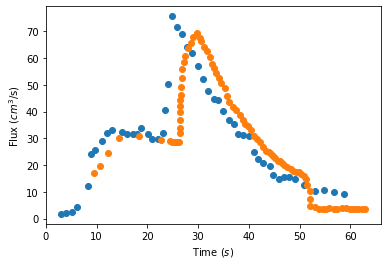

In [12]:
#[t10,t10,t20,f20,t30,f30]=readCSV_Ncol('Iwagaki_Data_3slopes.csv',6,2)
[t10,f10]=readCSV_Ncol('Iwagaki1955_t_10s.csv',2,0)
[tm10,fm10]=readCSV_Ncol('Iwagaki1955_theo_t_10s.csv',2,0)
ax1=plt.subplot(1,1,1)
P1,=ax1.plot(t10,f10,'o', label='Experiment')
P1,=ax1.plot(tm10,fm10,'o', label='model')
ax1.set_ylabel('Flux ($cm^3$/s)')
ax1.set_xlabel('Time ($s$)')


## Reading the BG_flood outputs

In [13]:
D=[]
for n in n_Manning:
    strName='n' + str(n)[2:] 
    fn = 'Output_' + strName + '.nc'
    D.append(nc4.Dataset(fn))

In [14]:
D[2]

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    maxlevel: 0
    minlevel: 0
    xmin: -0.006127678181023175
    xmax: 28.034127678181026
    ymin: -0.006127678181023175
    ymax: 0.18995802361171843
    dimensions(sizes): time(401), blockid(143), xx_P0(2288), yy_P0(16)
    variables(dimensions): float32 time(time), int32 blockid(blockid), float32 blockxo(blockid), float32 blockyo(blockid), float32 blockwidth(blockid), int32 blocklevel(blockid), int32 blockstatus(blockid), float64 xx_P0(xx_P0), float64 yy_P0(yy_P0), float32 zs_P0(time, yy_P0, xx_P0), float32 h_P0(time, yy_P0, xx_P0), float32 u_P0(time, yy_P0, xx_P0), float32 v_P0(time, yy_P0, xx_P0), float32 zb_P0(time, yy_P0, xx_P0), float32 hmax_P0(time, yy_P0, xx_P0), float32 zsmax_P0(time, yy_P0, xx_P0)
    groups: 

## Calculating the flux at the output

(Note: P0 in the output netCDF file refers to the refinement level.)

We calculate the flux through all a section located in $x=24m$. The flux is then normalised by the width of the section and multiply by 0.194 to compare with the experimental results.

Text(0.5, 0, 'Time (s)')

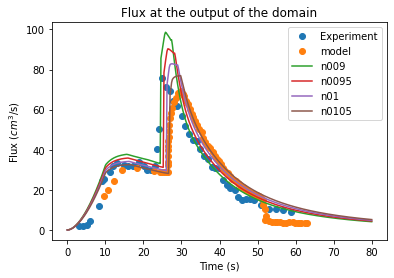

In [15]:

x_flux = 24

strName=[]
for n in n_Manning:
    strName.append('n' + str(n)[2:])
            
PP=[]
ax=plt.subplot(1,1,1)

P1,=ax.plot(t10,f10,'o', label='Experiment')
P2,=ax.plot(tm10,fm10,'o', label='model')
PP.append(P1)
PP.append(P2)

for n in [5,6,7,8]:#range(len(n_Manning)):
    
    xx=D[n]['xx_P0'][:]
    yy=D[n]['yy_P0'][:]
    tt=D[n]['time'][:]
    hh=D[n]['h_P0'][:,:,:]
    uu=D[n]['u_P0'][:]
    vv=D[n]['v_P0'][:]
    dx=xx[1]-xx[0]
    
    #find x-position nearest to the reference x=24m
    I=0
    dist_min=10^9
    for i in range(len(xx)):
        if abs(xx[i]-x_flux)<dist_min:
            I=i
            dist_min=abs(xx[i]-x_flux)

    
    F=[]
    for k in range(len(tt)):
        ft=0;
        for j in range(len(yy)):
            ft=ft+hh[k,j,I]*uu[k,j,I]*dx
        F.append(ft)

    #Change also units from m to cm
    Fnorm=[]
    Fpaper=[]
    for k in range(len(tt)):
        Fnorm.append(F[k]/(yy[-1]-yy[0])*100*100)
        Fpaper.append(F[k]/(yy[-1]-yy[0])*0.197*100*100)

    P='P' + str(n+2)
    P,=plt.plot(tt,Fnorm,'-', label=strName[n])
    PP.append(P)
    
plt.legend(handles=PP)
plt.title('Flux at the output of the domain')
plt.ylabel('Flux ($cm^3$/s)')
plt.xlabel('Time (s)')

    
    

#xx=ds['xx_P0'][:]
#yy=ds['yy_P0'][:]
#tt=ds['time'][:]
#hh=ds['h_P0'][:,:,:]
#uu=ds['u_P0'][:]
#vv=ds['v_P0'][:]
#dx=xx[1]-xx[0]

#find x-position nearest to the reference x=24m
#I=0
#dist_min=10^9
#for i in range(len(xx)):
#    if abs(xx[i]-x_flux)<dist_min:
#        I=i
#        dist_min=abs(xx[i]-x_flux)

    
#F=[]
#for k in range(len(tt)):
#    ft=0;
#    for j in range(len(yy)):
#        ft=ft+hh[k,j,I]*uu[k,j,I]*dx
#    F.append(ft)


Text(0.5, 0, 'Time (s)')

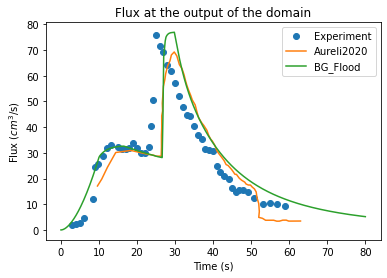

In [18]:
# version simplifiee du plot precedent:

x_flux = 24

strName=[]
for n in n_Manning:
    strName.append('n' + str(n)[2:])
            
PP=[]
ax=plt.subplot(1,1,1)

P1,=ax.plot(t10,f10,'o', label='Experiment')
P2,=ax.plot(tm10,fm10,'-', label='Aureli2020')
PP.append(P1)
PP.append(P2)

for n in [8]:#range(len(n_Manning)):
    
    xx=D[n]['xx_P0'][:]
    yy=D[n]['yy_P0'][:]
    tt=D[n]['time'][:]
    hh=D[n]['h_P0'][:,:,:]
    uu=D[n]['u_P0'][:]
    vv=D[n]['v_P0'][:]
    dx=xx[1]-xx[0]
    
    #find x-position nearest to the reference x=24m
    I=0
    dist_min=10^9
    for i in range(len(xx)):
        if abs(xx[i]-x_flux)<dist_min:
            I=i
            dist_min=abs(xx[i]-x_flux)

    
    F=[]
    for k in range(len(tt)):
        ft=0;
        for j in range(len(yy)):
            ft=ft+hh[k,j,I]*uu[k,j,I]*dx
        F.append(ft)

    #Change also units from m to cm
    Fnorm=[]
    Fpaper=[]
    for k in range(len(tt)):
        Fnorm.append(F[k]/(yy[-1]-yy[0])*100*100)
        Fpaper.append(F[k]/(yy[-1]-yy[0])*0.197*100*100)

    P='P' + str(n+2)
    P,=plt.plot(tt,Fnorm,'-', label='BG_Flood')
    PP.append(P)
    
plt.legend(handles=PP)
plt.title('Flux at the output of the domain')
plt.ylabel('Flux ($cm^3$/s)')
plt.xlabel('Time (s)')


## Evaluation of the influence of theta (scheme level)

In [55]:
cd ..

C:\Users\haranga\BG-Flood\Test_Cases_Alice\auto_Aureli2020_RainMap2


In [74]:
n_Manning=[0.009,0.01];
theta=[1.1,1.2,1.3,1.4,2.0];

In [70]:
for n in n_Manning:
    for t in theta:
        strName='n' + str(n)[2:] + '_theta' + str(t)[0] + '-' + str(t)[2:] 
    
        #Modify the BG_param file
        value[key.index('cf')] = n
        value[key.index('theta')] = t
        value[key.index('outfile')]='Output_' + strName + '.nc'

        #Save it
        data = np.column_stack([key, value])
        datafile_path = 'BG_param_' + strName + '.txt'
        np.savetxt(datafile_path , data, fmt=['%s ',' %s ;'], delimiter='=')
    
        #run BG_Flood for the appropriate BG_param file
        shutil.copy(datafile_path,'BG_param.txt')
        process=Popen('BG_flood.exe', stdout=PIPE, stderr=PIPE)
        stdout, stderr = process.communicate()

In [75]:
D=[]
for n in n_Manning:
    for t in theta:
        strName='n' + str(n)[2:] + '_theta' + str(t)[0] + '-' + str(t)[2:] 
        fn = 'Output_' + strName + '.nc'
        D.append(nc4.Dataset(fn))

In [76]:
strName


'n01_theta2-0'

Text(0.5, 0, 'Time (s)')

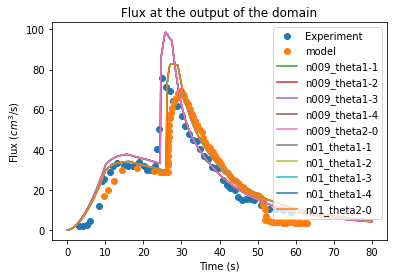

In [77]:

x_flux = 24

strName=[]
for n in n_Manning:
    for t in theta:
        strName.append('n' + str(n)[2:] + '_theta' + str(t)[0] + '-' + str(t)[2:])
            
PP=[]
ax=plt.subplot(1,1,1)

P1,=ax.plot(t10,f10,'o', label='Experiment')
P2,=ax.plot(tm10,fm10,'o', label='model')
PP.append(P1)
PP.append(P2)

for n in range(len(strName)):
    
    xx=D[n]['xx_P0'][:]
    yy=D[n]['yy_P0'][:]
    tt=D[n]['time'][:]
    hh=D[n]['h_P0'][:,:,:]
    uu=D[n]['u_P0'][:]
    vv=D[n]['v_P0'][:]
    dx=xx[1]-xx[0]
    
    #find x-position nearest to the reference x=24m
    I=0
    dist_min=10^9
    for i in range(len(xx)):
        if abs(xx[i]-x_flux)<dist_min:
            I=i
            dist_min=abs(xx[i]-x_flux)

    
    F=[]
    for k in range(len(tt)):
        ft=0;
        for j in range(len(yy)):
            ft=ft+hh[k,j,I]*uu[k,j,I]*dx
        F.append(ft)

    #Change also units from m to cm
    Fnorm=[]
    Fpaper=[]
    for k in range(len(tt)):
        Fnorm.append(F[k]/(yy[-1]-yy[0])*100*100)
        Fpaper.append(F[k]/(yy[-1]-yy[0])*0.197*100*100)

    P='P' + str(n+2)
    P,=plt.plot(tt,Fnorm,'-', label=strName[n])
    PP.append(P)
    
plt.legend(handles=PP)
plt.title('Flux at the output of the domain')
plt.ylabel('Flux ($cm^3$/s)')
plt.xlabel('Time (s)')


## Interpolation of observations to get experiment for regular times steps

### Using values from the experiment (no longer used)

array([ 1.75136262,  4.31856716, 24.36350225, 32.02235696, 32.41207121,
       31.68632601, 29.8140878 , 47.9632521 , 68.78608061, 57.03656989])

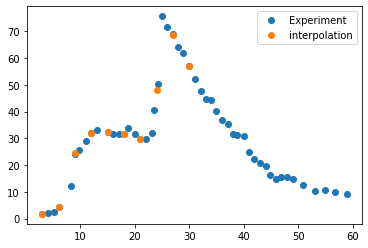

In [95]:
ax1=plt.subplot(1,1,1)
P1,=ax1.plot(t10,f10,'o', label='Experiment')

T_out=np.linspace(3,30,10)
Obs_out=T_out
Obs_out=np.interp(T_out, t10, f10, left=0.0);
P2,=ax1.plot(T_out,Obs_out,'o', label='interpolation')
plt.legend(handles=[P1,P2])
Obs_out

### Using values from BG_flood run (theta = 1.3 / default and Manning coef = 0.009 )

In [98]:
n=0.009
t=1.3
strName='n' + str(n)[2:] + '_theta' + str(t)[0] + '-' + str(t)[2:]
fn = 'Output_' + strName + '.nc'
D=nc4.Dataset(fn)

xx=D['xx_P0'][:]
yy=D['yy_P0'][:]
tt=D['time'][:]
hh=D['h_P0'][:,:,:]
uu=D['u_P0'][:]
vv=D['v_P0'][:]
dx=xx[1]-xx[0]
    
#find x-position nearest to the reference x=24m
I=0
dist_min=10^9
for i in range(len(xx)):
    if abs(xx[i]-x_flux)<dist_min:
        I=i
        dist_min=abs(xx[i]-x_flux)

    
F=[]
for k in range(len(tt)):
    ft=0;
    for j in range(len(yy)):
        ft=ft+hh[k,j,I]*uu[k,j,I]*dx
    F.append(ft)

#Change also units from m to cm
Fnorm=[]
for k in range(len(tt)):
    Fnorm.append(F[k]/(yy[-1]-yy[0])*100*100)

Ref_out=np.interp(T_out, tt, Fnorm);

array([ 3.91529345, 13.25190688, 26.80124094, 35.66923489, 37.53384948,
       36.48744275, 35.05542626, 33.29121321, 95.42833765, 62.4640137 ])

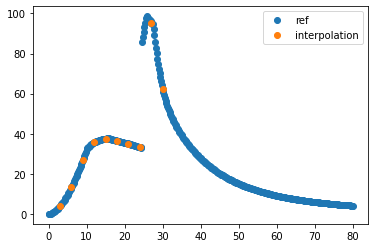

In [100]:
ax1=plt.subplot(1,1,1)
P1,=ax1.plot(tt,Fnorm,'o', label='ref')
P2,=ax1.plot(T_out,Ref_out,'o', label='interpolation')
plt.legend(handles=[P1,P2])
Ref_out

In [94]:
T_out

array([ 3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30.])